In [1]:
import sys
sys.path.append("D:/trading")

In [2]:
import pandas as pd
import numpy as np
import itertools
from joblib import Parallel, delayed
from tqdm import tqdm

# Cargar históricos locales
import os
ruta_historicos = "D:/trading/data/historic"
historicos = {}
for archivo in os.listdir(ruta_historicos):
    if archivo.endswith(".parquet"):
        ticker = archivo.replace(".parquet", "")
        df = pd.read_parquet(os.path.join(ruta_historicos, archivo))
        historicos[ticker] = df
print(f"Símbolos cargados: {len(historicos)}")




Símbolos cargados: 48


In [3]:
param_grid = list(itertools.product(
    [0.02, 0.03, 0.04],       # umbral_gap
    [0.005, 0.01, 0.015],     # gap_min_abs_pct
    [True, False]             # usar_confirmacion_cuerpo
))
print(f"Total combinaciones: {len(param_grid)}")

Total combinaciones: 18


In [4]:
# ✅ CELDA 3: Simulación por combinación
from my_modules.estrategias.v4 import gap_open_strategy_v4

def simular_combinacion(params):
    umbral_gap, gap_min_abs, usar_confirm = params
    resultados = []

    for ticker, df_precio in historicos.items():
        df_signals = gap_open_strategy_v4.generar_senales(
            df_precio,
            umbral_gap=umbral_gap,
            gap_min_abs_pct=gap_min_abs,
            usar_confirmacion_cuerpo=usar_confirm,
            debug=False
        )
        df_signals = df_signals[df_signals["signal"] != "hold"]
        if df_signals.empty:
            continue

        df_precio = df_precio.copy()
        df_precio = df_precio.merge(df_signals[["fecha", "signal"]], on="fecha")

        for _, row in df_precio.iterrows():
            fecha_entrada = row["fecha"]
            precio_entrada = row["close"]
            df_rango = df_precio[(df_precio["fecha"] > fecha_entrada) & (df_precio["fecha"] <= fecha_entrada + pd.Timedelta(days=7))]
            if df_rango.empty:
                continue

            tipo_salida = "TIMEOUT"
            fila_salida = df_rango.iloc[-1]

            for _, f in df_rango.iterrows():
                if row["signal"] == "buy":
                    if f["high"] >= precio_entrada * 1.05:
                        tipo_salida = "TP"; fila_salida = f; break
                    if f["low"] <= precio_entrada * 0.97:
                        tipo_salida = "SL"; fila_salida = f; break
                elif row["signal"] == "sell":
                    if f["low"] <= precio_entrada * 0.95:
                        tipo_salida = "TP"; fila_salida = f; break
                    if f["high"] >= precio_entrada * 1.03:
                        tipo_salida = "SL"; fila_salida = f; break

            precio_salida = fila_salida["close"]
            dias = (fila_salida["fecha"] - fecha_entrada).days
            resultado = precio_salida - precio_entrada if row["signal"] == "buy" else precio_entrada - precio_salida
            ret_pct = (precio_salida / precio_entrada - 1) * (1 if row["signal"] == "buy" else -1)
            log_ret = np.log(precio_salida / precio_entrada) * (1 if row["signal"] == "buy" else -1)

            resultados.append({
                "resultado": resultado,
                "resultado_pct": ret_pct,
                "log_ret": log_ret,
                "f_win": int(resultado > 0),
                "dias": dias
            })

    df = pd.DataFrame(resultados)
    if df.empty:
        return {
            "umbral_gap": umbral_gap,
            "gap_min_abs_pct": gap_min_abs,
            "usar_confirmacion_cuerpo": usar_confirm,
            "n_trades": 0,
            "winrate": 0,
            "avg_profit": 0,
            "score": -999
        }

    return {
        "umbral_gap": umbral_gap,
        "gap_min_abs_pct": gap_min_abs,
        "usar_confirmacion_cuerpo": usar_confirm,
        "n_trades": len(df),
        "winrate": df["f_win"].mean(),
        "avg_profit": df["resultado"].mean(),
        "score": df["resultado"].mean() * df["f_win"].mean()
    }


In [5]:
# ✅ CELDA 4: Ejecutar grid y visualizar resultados
resultados = Parallel(n_jobs=-1)(
    delayed(simular_combinacion)(params) for params in tqdm(param_grid)
)

df_tuning = pd.DataFrame(resultados).sort_values("score", ascending=False).reset_index(drop=True)
print("Top combinaciones por score:")
display(df_tuning.head(10))





100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:11<00:00,  1.53it/s]


Top combinaciones por score:


umbral_gap  gap_min_abs_pct  usar_confirmacion_cuerpo  n_trades   winrate  \
0        0.04            0.015                     False      1353  0.521803   
1        0.04            0.010                     False      1353  0.521803   
2        0.04            0.005                     False      1353  0.521803   
3        0.03            0.005                     False      2827  0.502653   
4        0.03            0.015                     False      2827  0.502653   
5        0.03            0.010                     False      2827  0.502653   
6        0.02            0.010                     False      7458  0.488871   
7        0.02            0.005                     False      7458  0.488871   
8        0.02            0.015                     False      7458  0.488871   
9        0.04            0.010                      True       510  0.472549   

   avg_profit     score  
0    0.244179  0.127414  
1    0.244179  0.127414  
2    0.244179  0.127414  
3    0.067774  0.034067  
4    0.067774  0.034067  
5    0.067774  0.034067  
6    0.008786  0.004295  
7    0.008786  0.004295  
8    0.008786  0.004295  
9   -0.057210 -0.027034

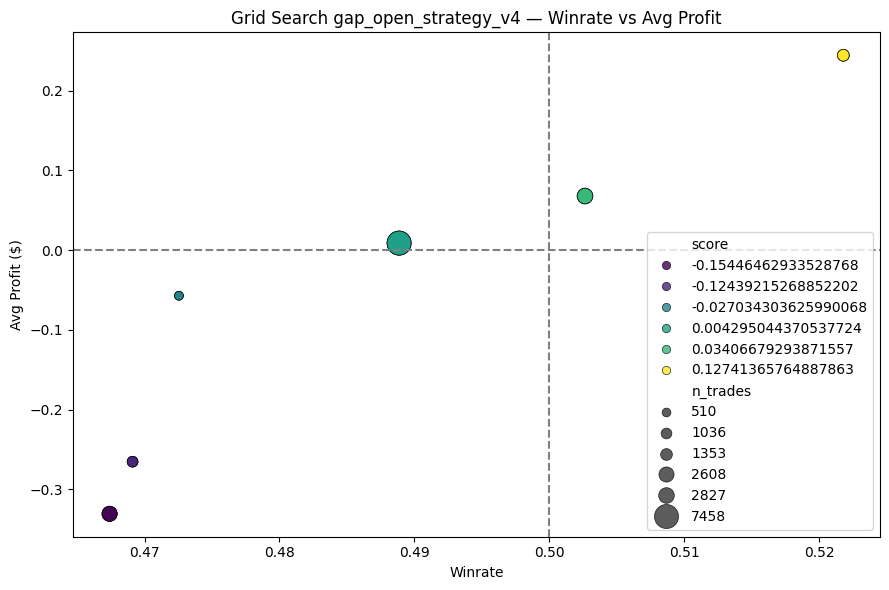

In [6]:
# ✅ CELDA 5: Visualizar scatterplot
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(9, 6))
sns.scatterplot(
    data=df_tuning,
    x="winrate",
    y="avg_profit",
    size="n_trades",
    hue="score",
    palette="viridis",
    sizes=(40, 300),
    edgecolor="black",
    alpha=0.8
)
plt.axhline(0, color="gray", linestyle="--")
plt.axvline(0.5, color="gray", linestyle="--")
plt.title("Grid Search gap_open_strategy_v4 — Winrate vs Avg Profit")
plt.xlabel("Winrate")
plt.ylabel("Avg Profit ($)")
plt.tight_layout()
plt.show()